# Task 2 - Apartment Rent Prediction using Decision Tree Regressor  

**Objective:** Predict rental prices using Spark MLlib Decision Tree Regressor.  

This notebook follows the same preprocessing as the Naive Bayes classification notebook,  
but replaces classification with a **Decision Tree Regressor** for continuous price prediction.


In [1]:
pip install pyspark


  Using cached pyspark-4.0.0.tar.gz (434.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Running setup.py install for pyspark: started
  Running setup.py install for pyspark: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: pyspark is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for pyspark did not run successfully.
  │ exit code: 1
  ╰─> [1393 lines of output]
      running install
      C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_py
      creating build
      creating build\lib
      creating build\lib\pyspark
      copying pyspark\accumulators.py -> build\lib\pyspark
     

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import RFormula, StringIndexer, VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder \
    .appName("RentalPriceDecisionTree") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

Spark Version: 4.0.0


In [ ]:
## Discover and Visualize the Data

# Load CSV directly with Spark (more robust than pandas for big CSVs)
path = "apartments_for_rent_classified_100K.csv"
df_spark = spark.read.csv(
    path,
    header=True,
    sep=";",
    inferSchema=True,
    multiLine=True,
    escape='"'
)

# Rename columns: lower-case, replace spaces with underscores
for c in df_spark.columns:
    df_spark = df_spark.withColumnRenamed(c, c.strip().lower().replace(" ", "_"))

print("=== RAW DATA SAMPLE ===")
df_spark.show(5, truncate=False)

# ================================
# Train-Test Split (first)
# ================================
train_raw, test_raw = df_spark.randomSplit([0.8, 0.2], seed=42)
print(f"Training rows: {train_raw.count()}, Test rows: {test_raw.count()}")

# ================================
# Preprocessing Function
# ================================
def preprocess(df):
    # --- Clean PRICE ---
    df_clean = df.withColumn(
        "price_num",
        regexp_replace(col("price").cast("string"), "[^0-9]", "")
    )
    df_clean = df_clean.withColumn("price_num", expr("try_cast(price_num as double)"))
    df_clean = df_clean.filter(col("price_num").isNotNull() & (col("price_num") > 0))

    # --- Clean numeric columns ---
    numeric_cols = ['bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude']
    for col_name in numeric_cols:
        if col_name in df_clean.columns:
            df_clean = df_clean.withColumn(
                col_name,
                regexp_replace(col(col_name).cast("string"), "[^0-9.-]", "")
            )
            df_clean = df_clean.withColumn(col_name, expr(f"try_cast({col_name} as double)"))

    # --- Fill missing values ---
    df_clean = df_clean.fillna({
        'bedrooms': 1.0, 'bathrooms': 1.0, 'square_feet': 500.0,
        'latitude': 0.0, 'longitude': 0.0,
        'cityname': 'Unknown', 'state': 'Unknown',
        'pets_allowed': 'Unknown', 'has_photo': 'No', 'source': 'Unknown'
    })

    # --- Feature Engineering (original features) ---
    df_clean = df_clean.withColumn(
        "price_per_sqft",
        when(col("square_feet") > 0, col("price_num") / col("square_feet")).otherwise(0.0)
    )
    df_clean = df_clean.withColumn("total_rooms", col("bedrooms") + col("bathrooms"))
    df_clean = df_clean.withColumn("location_score", abs(col("latitude")) + abs(col("longitude")))
    df_clean = df_clean.withColumn(
        "room_density",
        when(col("square_feet") > 0, (col("bedrooms") + col("bathrooms")) / col("square_feet")).otherwise(0.0)
    )

    return df_clean

# Apply preprocessing
train_data = preprocess(train_raw)
test_data = preprocess(test_raw)

print("After preprocessing (sample):")
train_data.select("price_num", "bedrooms", "bathrooms", "square_feet", "price_per_sqft").show(5)

=== RAW DATA SAMPLE ===
+----------+----------------------+-------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------+--------+--------+---+---------+------------+-----+-------------+----------+-----------+-------------------+-------------+-----+--------+---------+---------+----------+
|id        |category              |title                          |body                                                                                                                                                        |amenities|bathrooms|bedrooms|currency|fee|has_photo|pets_allowed|price|price_display|price_type|square_feet|address            |cityname     |state|latitude|longitude|source   |time      |
+----------+----------------------+-------------------------------+-----------------------------------------------------------------------------------

In [ ]:
# ================================
# RFormula Example
# ================================
# Requirement: at least one feature defined by RFormula
formula = RFormula(
    formula="price_num ~ bedrooms + bathrooms + square_feet + state",
    featuresCol="features_rformula",
    labelCol="price_num"
)

train_rformula = formula.fit(train_data).transform(train_data)
train_rformula.select("features_rformula", "price_num").show(5, truncate=False)

+------------------------------------+---------+
|features_rformula                   |price_num|
+------------------------------------+---------+
|(54,[0,1,2,12],[1.0,1.0,800.0,1.0]) |1191.0   |
|(54,[0,1,2,8],[4.0,2.0,1880.0,1.0]) |1450.0   |
|(54,[0,1,2,8],[3.0,2.0,1400.0,1.0]) |1255.0   |
|(54,[0,1,2,12],[2.0,2.0,1346.0,1.0])|1693.0   |
|(54,[0,1,2,40],[2.0,2.0,1241.0,1.0])|2945.0   |
+------------------------------------+---------+
only showing top 5 rows


In [ ]:
# ================================
# Decision Tree Pipeline
# ================================
# Index categorical variables
categorical_cols = ['state', 'has_photo']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep") 
            for col in categorical_cols]

# Assemble engineered features
engineered_features = [
    'bedrooms', 'bathrooms', 'square_feet',
    'price_per_sqft', 'total_rooms', 'location_score', 'room_density'
] + [f"{col}_idx" for col in categorical_cols]

assembler = VectorAssembler(inputCols=engineered_features, outputCol="features_manual")

# Decision Tree model
dt = DecisionTreeRegressor(featuresCol="features_manual", labelCol="price_num", maxDepth=10, maxBins=100)

# Build pipeline
pipeline = Pipeline(stages=indexers + [assembler, dt])
dt_model = pipeline.fit(train_data)

# Predictions
predictions = dt_model.transform(test_data)
predictions.select("features_manual", "price_num", "prediction").show(5, truncate=False)

# ================================
# Evaluation
# ================================
evaluator_rmse = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Decision Tree RMSE: {rmse:.2f}")
print(f"Decision Tree MAE: {mae:.2f}")
print(f"Decision Tree R2: {r2:.2f}")

+----------------------------------------------------------------------------------------+---------+------------------+
|features_manual                                                                         |price_num|prediction        |
+----------------------------------------------------------------------------------------+---------+------------------+
|[3.0,2.0,1661.0,0.839855508729681,5.0,111.92859999999999,0.0030102347983142685,5.0,0.0] |1395.0   |1385.628205128205 |
|[2.0,2.0,975.0,1.1384615384615384,4.0,111.92859999999999,0.0041025641025641026,5.0,0.0] |1110.0   |1111.198738170347 |
|[1.0,1.0,946.0,2.9651162790697674,2.0,168.2103,0.0021141649048625794,37.0,0.0]          |2805.0   |2815.686567164179 |
|[2.0,2.0,1078.0,0.9257884972170687,4.0,111.92859999999999,0.0037105751391465678,5.0,0.0]|998.0    |1038.4309392265193|
|[2.0,2.0,1138.0,1.0764499121265378,4.0,111.92859999999999,0.0035149384885764497,5.0,0.0]|1225.0   |1190.985655737705 |
+---------------------------------------

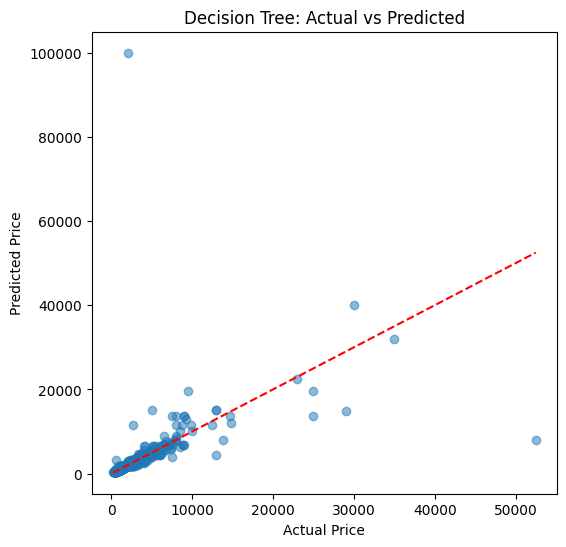

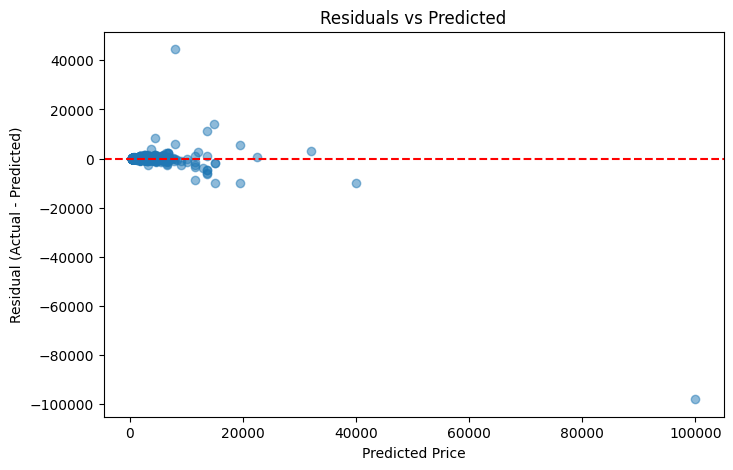


=== MODEL PERFORMANCE COMPARISON ===
                                              Model       RMSE        MAE  \
0  Decision Tree (manual features + RFormula check)  800.86668  57.276232   

         R2  
0  0.343645  


In [ ]:
# ================================
# Comparison Table
# ================================
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for plotting
pdf = predictions.select("price_num", "prediction").toPandas()

# Residuals
pdf["residuals"] = pdf["price_num"] - pdf["prediction"]

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6,6))
plt.scatter(pdf["price_num"], pdf["prediction"], alpha=0.5)
plt.plot([pdf["price_num"].min(), pdf["price_num"].max()],
         [pdf["price_num"].min(), pdf["price_num"].max()],
         color="red", linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Decision Tree: Actual vs Predicted")
plt.show()

# --- Plot 2: Residuals vs Predicted ---
plt.figure(figsize=(8,5))
plt.scatter(pdf["prediction"], pdf["residuals"], alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()

results_df = pd.DataFrame({
    "Model": ["Decision Tree (manual features + RFormula check)"],
    "RMSE": [rmse],
    "MAE": [mae],
    "R2": [r2]
})

print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(results_df)

In [ ]:
# ================================
# Fine-Tuning the Decision Tree
# ================================
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Build parameter grid for tuning
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 15])     # test different depths
             .addGrid(dt.maxBins, [64, 128, 256])    # test different bin sizes
             .build())

# Evaluator (use RMSE here, but could also try R2 or MAE)
evaluator = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="rmse")

# Cross-validation setup
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Fit cross-validation model
cv_model = crossval.fit(train_data)

# Best model predictions
cv_predictions = cv_model.transform(test_data)

# Evaluate tuned model
rmse_tuned = evaluator.evaluate(cv_predictions)
mae_tuned = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="mae").evaluate(cv_predictions)
r2_tuned = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="r2").evaluate(cv_predictions)

print(f"Tuned Decision Tree RMSE: {rmse_tuned:.2f}")
print(f"Tuned Decision Tree MAE: {mae_tuned:.2f}")
print(f"Tuned Decision Tree R2: {r2_tuned:.2f}")


Tuned Decision Tree RMSE: 340.69
Tuned Decision Tree MAE: 21.55
Tuned Decision Tree R2: 0.88


In [ ]:
# ================================
# Updated Comparison Table
# ================================
results_df = pd.DataFrame({
    "Model": [
        "Decision Tree (baseline)",
        "Decision Tree (fine-tuned)"
    ],
    "RMSE": [rmse, rmse_tuned],
    "MAE": [mae, mae_tuned],
    "R2": [r2, r2_tuned]
})

print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(results_df)



=== MODEL PERFORMANCE COMPARISON ===
                        Model        RMSE        MAE        R2
0    Decision Tree (baseline)  800.866680  57.276232  0.343645
1  Decision Tree (fine-tuned)  340.686941  21.550831  0.881224
